# Exploration and ML Models with Sampled NYC Taxi Trip and Fare Dataset using Scala

###### Expected time to run this Notebook: 
About 5 mins on a HDInsight Spark (version 1.6) cluster with 4 worker nodes (D12)

## INTRODUCTION, OBJECTIVE AND ORGANIZATION

### INTRODUCTION
Here we show some features and capabilities of Spark's MLlib and SparkML toolkits for supervised machine learning (ML) problems using <a href="http://www.andresmh.com/nyctaxitrips/" target="_blank">the NYC taxi trip and fare data-set from 2013</a>. We take a 0.1% sample of this data-set (about 170K rows, 35 Mb) to to show an end-to-end data science process, including data exploration, visualization, modeling, model saving, and scoring for binary classification and regression problems using this data-set. 

This notebook is written in Scala. We have released similar notebooks in <a href="https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-spark-overview/" target="_blank">Python</a> earlier to show how to perform end-to-end data-science process. We provide a shorter version of the notebook here, showing the process and functions in Scala.

### OBJECTIVE: To show use of Spark's native Spark ML and MLlib machine learning functions for ML tasks using Scala


#### We address two common supervised machine learning tasks
1. Regression problem: Prediction of the tip amonut ($)
2. Binary classification: Prediction of tip or no-tip (1/0) for a taxi trip

#### Modeling section is be split into steps: 
1. Model training 
2. Model evaluation on a test data set with relevant accuracy metrics
3. Saving model in Azure blob for future consumption
4. Loading a saved model to score a data-set

We present three appreaches: linear (logistic or linear regression), Random Forest and Boosted Trees.


#### NOTES:
1. At this time models can be created using MLlib (with RDDs) as well as Spark ML functions (with data-frames). As of Spark version 1.6, there are some limitations in terms of available functions to save/load models created using Spark ML functions (e.g. Cross-validator models from various modeling approaches besides linear models).

2. For using tree-based modeling functions from Spark ML and MLlib, target and features have to be indexed or vectorized appropriately. We have shown how to accomplish this in the data preparation and feature engineering section.

### ORGANIZATION: We have organized this walkthrough into the following sections: 

#### [1. Data ingestion from public blob](#ingestion)
Ingests CSV file, creates data-frame, and registre temporary table

#### [2. Data exploration & visualization](#exploration)
Visualize data using Jupyter's autovisualization features, as well as, Python's matplotlib functions on pandas data-frames

#### [3. Data preparation, feature engineering, and feature transformation](#transformation)
Index categorical features, convert numerical variable to categorical using SQL, create RRDs (LabeledPoint) and data-frames for input into modeling functions

#### [4. Binary classification problem: Modeling, model evaluation and persistance](#binary)
Create binary classification models, save model in blob, and evaluate model on test data

#### [5. Regression problem: Modeling, model evaluation, and persistance](#regression)
Create regression models, save model in blob, load model, and evaluate test data

#### [6. Advanced training with cross-validation and model hyper-parameter tuning](#advanced)
We show how to optimize model using CV or train-validation split and model hyper-parameter sweeping

#### [7. Automated scoring and consumption of ML models built on Spark](#consumption)
We provide pointers describing how a saved ML model can be used to automatically score new data-sets

### BACKGROUND

1. <a href="https://azure.microsoft.com/en-us/documentation/articles/hdinsight-apache-spark-zeppelin-notebook-jupyter-spark-sql/" target="_blank">How to provision a HDI cluster running Spark</a>

2. <a href="http://www.andresmh.com/nyctaxitrips/" target="_blank">NYC 2013 Taxi data</a>

<hr>

In [1]:
import java.util.Calendar
val beginningTime = Calendar.getInstance().getTime()

Creating SparkContext as 'sc'
Creating HiveContext as 'sqlContext'
beginningTime: java.util.Date = Mon Jun 27 19:46:58 UTC 2016

<hr>

### IMPORT FUNCTIONS

In [2]:
import org.apache.spark.sql.SQLContext
import org.apache.spark.sql.functions._
import java.text.SimpleDateFormat
import java.util.Calendar
import sqlContext.implicits._
import org.apache.spark.sql.Row

// Spark SQL functions
import org.apache.spark.sql.types.{StructType, StructField, StringType, IntegerType, FloatType, DoubleType}
import org.apache.spark.sql.functions.rand

// Spark ML functions
import org.apache.spark.ml.Pipeline
import org.apache.spark.ml.feature.{StringIndexer, VectorAssembler, OneHotEncoder, VectorIndexer, Binarizer}
import org.apache.spark.ml.tuning.{ParamGridBuilder, TrainValidationSplit, CrossValidator}
import org.apache.spark.ml.regression.{LinearRegression, LinearRegressionModel, RandomForestRegressor, RandomForestRegressionModel, GBTRegressor, GBTRegressionModel}
import org.apache.spark.ml.classification.{LogisticRegression, LogisticRegressionModel, RandomForestClassifier, RandomForestClassificationModel, GBTClassifier, GBTClassificationModel}
import org.apache.spark.ml.evaluation.{BinaryClassificationEvaluator, RegressionEvaluator, MulticlassClassificationEvaluator}

// MLlib functions
import org.apache.spark.mllib.linalg.{Vector, Vectors}
import org.apache.spark.mllib.util.MLUtils
import org.apache.spark.mllib.classification.{LogisticRegressionWithLBFGS, LogisticRegressionModel}
import org.apache.spark.mllib.regression.{LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel}
import org.apache.spark.mllib.tree.{GradientBoostedTrees, RandomForest}
import org.apache.spark.mllib.tree.configuration.BoostingStrategy
import org.apache.spark.mllib.tree.model.{GradientBoostedTreesModel, RandomForestModel, Predict}
import org.apache.spark.mllib.evaluation.{BinaryClassificationMetrics, MulticlassMetrics, RegressionMetrics}

val sqlContext = new SQLContext(sc)

sqlContext: org.apache.spark.sql.SQLContext = org.apache.spark.sql.SQLContext@f7327e

<hr>

<a name="ingestion"></a>
## 1. DATA INGESTION: Read in joined 0.1% taxi trip and fare file (as tsv), format and clean data, and create data-frame

###### Specify location of input file and storage location for models in the Azure blob taht is attached to the cluster

In [3]:
// Location of training data
val taxi_train_file = sc.textFile("wasb://mllibwalkthroughs@cdspsparksamples.blob.core.windows.net/Data/NYCTaxi/JoinedTaxiTripFare.Point1Pct.Train.tsv")
val header = taxi_train_file.first;

// Set model storage directory path. This is where models will be saved.
val modelDir = "wasb:///user/remoteuser/NYCTaxi/Models/"; //The last backslash is needed;

modelDir: String = wasb:///user/remoteuser/NYCTaxi/Models/

###### Import data, create RDD and define data-frame according to schema

In [4]:
val starttime = Calendar.getInstance().getTime()

/* DEFINE SCHEMA BASED ON HEADER OF THE FILE */
val sqlContext = new SQLContext(sc)
val taxi_schema = StructType(
    Array(
        StructField("medallion", StringType, true), 
        StructField("hack_license", StringType, true),
        StructField("vendor_id", StringType, true), 
        StructField("rate_code", DoubleType, true),
        StructField("store_and_fwd_flag", StringType, true),
        StructField("pickup_datetime", StringType, true),
        StructField("dropoff_datetime", StringType, true),
        StructField("pickup_hour", DoubleType, true),
        StructField("pickup_week", DoubleType, true),
        StructField("weekday", DoubleType, true),
        StructField("passenger_count", DoubleType, true),
        StructField("trip_time_in_secs", DoubleType, true),
        StructField("trip_distance", DoubleType, true),
        StructField("pickup_longitude", DoubleType, true),
        StructField("pickup_latitude", DoubleType, true),
        StructField("dropoff_longitude", DoubleType, true),
        StructField("dropoff_latitude", DoubleType, true),
        StructField("direct_distance", StringType, true),
        StructField("payment_type", StringType, true),
        StructField("fare_amount", DoubleType, true),
        StructField("surcharge", DoubleType, true),
        StructField("mta_tax", DoubleType, true),
        StructField("tip_amount", DoubleType, true),
        StructField("tolls_amount", DoubleType, true),
        StructField("total_amount", DoubleType, true),
        StructField("tipped", DoubleType, true),
        StructField("tip_class", DoubleType, true)
        )
    )

/* CAST VARIABLES ACCORDING TO SCHEMA */
val taxi_temp = (taxi_train_file.map(_.split("\t"))
                        .filter((r) => r(0) != "medallion")
                        .map(p => Row(p(0), p(1), p(2),
                            p(3).toDouble, p(4), p(5), p(6), p(7).toDouble, p(8).toDouble, p(9).toDouble, p(10).toDouble,
                            p(11).toDouble, p(12).toDouble, p(13).toDouble, p(14).toDouble, p(15).toDouble, p(16).toDouble,
                            p(17), p(18), p(19).toDouble, p(20).toDouble, p(21).toDouble, p(22).toDouble,
                            p(23).toDouble, p(24).toDouble, p(25).toDouble, p(26).toDouble)))


/* CREATE INITIAL DATA-FRAME, DROP COLUMNS, AND CREATE CLEANED DATA-FRAME BY FILTERING FOR UNDESIRED VALUES OR OUTLIERS */
val taxi_train_df = sqlContext.createDataFrame(taxi_temp, taxi_schema)

val taxi_df_train_cleaned = (taxi_train_df.drop(taxi_train_df.col("medallion"))
        .drop(taxi_train_df.col("hack_license")).drop(taxi_train_df.col("store_and_fwd_flag"))
        .drop(taxi_train_df.col("pickup_datetime")).drop(taxi_train_df.col("dropoff_datetime"))
        .drop(taxi_train_df.col("pickup_longitude")).drop(taxi_train_df.col("pickup_latitude"))
        .drop(taxi_train_df.col("dropoff_longitude")).drop(taxi_train_df.col("dropoff_latitude"))
        .drop(taxi_train_df.col("surcharge")).drop(taxi_train_df.col("mta_tax"))
        .drop(taxi_train_df.col("direct_distance")).drop(taxi_train_df.col("tolls_amount"))
        .drop(taxi_train_df.col("total_amount")).drop(taxi_train_df.col("tip_class"))
        .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 150 AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200"));

/* CACHE AND MATERIALIZE CLEANED DATA-FRAME IN MEMORY */
taxi_df_train_cleaned.cache()
taxi_df_train_cleaned.count()

/* REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT */
taxi_df_train_cleaned.registerTempTable("taxi_train")

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

Time taken to run the above cell: 8 seconds.

###### Query table and import results in a data-frame

In [5]:
val sqlStatement = """
    SELECT fare_amount, passenger_count, tip_amount, tipped
    FROM taxi_train 
    WHERE passenger_count > 0 AND passenger_count < 7
    AND fare_amount > 0 AND fare_amount < 200
    AND payment_type in ('CSH', 'CRD')
    AND tip_amount > 0 AND tip_amount < 25
"""
val sqlResultsDF = sqlContext.sql(sqlStatement)

sqlResultsDF.show(3)

+-----------+---------------+----------+------+
|fare_amount|passenger_count|tip_amount|tipped|
+-----------+---------------+----------+------+
|       13.5|            1.0|       2.9|   1.0|
|       16.0|            2.0|       3.4|   1.0|
|       10.5|            2.0|       1.0|   1.0|
+-----------+---------------+----------+------+
only showing top 3 rows

<hr>

<a name="exploration"></a>
## 2. DATA EXPLORATION AND VISUALIZATION: Plotting of target variables and features

###### Query a table and import results into data-frame, create a local pandas data-frame, and then visualize using Jupyter's autovisualization feature

###### NOTE: 
You can use the <b>`%%local`</b> magic to run your code locally on the Jupyter server, which is the headnode of the HDInsight cluster. Here's a typical use case for this scenario. 

By default, the output of any code snippet that you run from a Jupyter notebook is available within the context of the session that is persisted on the worker nodes. However, if you want to save a trip to the worker nodes for every computation, and all the data that you need for your computation is available locally on the Jupyter server node (which is the headnode), you can use the `%%local` magic to run the code snippet on the Jupyter server. Typically, you would use `%%local` magic in conjunction with the `%%sql` magic with `-o` parameter. The `-o` parameter would persist the output of the SQL query locally and then `%%local` magic would trigger the next set of code snippet to run locally against the output of the SQL queries that is persisted locally.

In the cells below, the %%local magic creates a local data-frame, sqlResults, which can be used for plotting using matplotlib. This is used multiple times in this walkthrough. <b>If the amount of data is large, please sample to create a data-frame that can fit in local memory</b>.

----------
##### NOTE:

Automatic visualization of queries 

The Pyspark kernel automatically visualizes the output of SQL (HiveQL) queries. You are given the option to choose between several different types of visualizations:
- Table
- Pie
- Line 
- Area
- Bar

In [6]:
%%sql -q -o sqlResults
SELECT fare_amount, passenger_count, tip_amount, tipped FROM taxi_train WHERE passenger_count > 0 AND passenger_count < 7 AND fare_amount > 0 AND fare_amount < 200 AND payment_type in ('CSH', 'CRD') AND tip_amount > 0 AND tip_amount < 25

### Visualize using Jupyter autovisualization feature

In [7]:
%%local
sqlResults

### One can plot using Python code once the data-frame is in local context as pandas data-frame

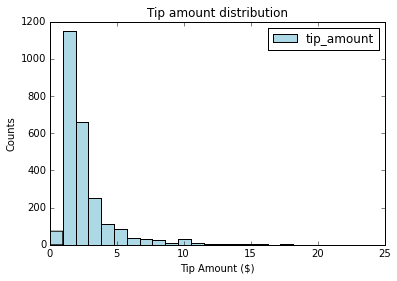

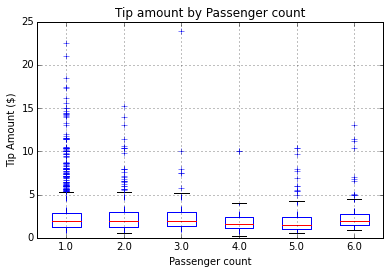

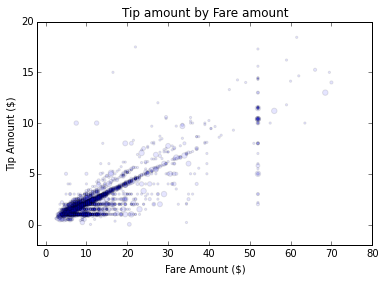

In [8]:
%%local
import matplotlib.pyplot as plt
%matplotlib inline

# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = sqlResults[['tip_amount']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)')
ax1.set_ylabel('Counts')
plt.suptitle('')
plt.show()

# TIP BY PASSENGER COUNT
ax2 = sqlResults.boxplot(column=['tip_amount'], by=['passenger_count'])
ax2.set_title('Tip amount by Passenger count')
ax2.set_xlabel('Passenger count')
ax2.set_ylabel('Tip Amount ($)')
plt.suptitle('')
plt.show()

# TIP AMOUNT BY FARE AMOUNT, POINTS ARE SCALED BY PASSENGER COUNT
ax = sqlResults.plot(kind='scatter', x= 'fare_amount', y = 'tip_amount', c='blue', alpha = 0.10, s=5*(sqlResults.passenger_count))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)')
ax.set_ylabel('Tip Amount ($)')
plt.axis([-2, 80, -2, 20])
plt.show()

<a name="transformation"></a>
## 3. CREATING FEATURES, TRANSFORMATION OF FEATURES, AND DATA PREP FOR INPUT INTO MODELING FUNCTIONS

### Create a new feature by binning hours into traffic time buckets

In [9]:
/* CREATE FOUR BUCKETS FOR TRAFFIC TIMES */
val sqlStatement = """
    SELECT *,
    CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_train 
"""
val taxi_df_train_with_newFeatures = sqlContext.sql(sqlStatement)

/* CACHE DATA-FRAME IN MEMORY & MATERIALIZE DF IN MEMORY */
taxi_df_train_with_newFeatures.cache()
taxi_df_train_with_newFeatures.count()

res35: Long = 126050

### Indexing and one-hot encoding of categorical features

Here we only transform four variables to show examples, which are character strings. Other variables, such as week-day, which are represented by numerical valies, can also be indexed as categorical variables.

For indexing, we used stringIndexer, and for one-hot encoding, we used OneHotEncoder functions from MLlib.

In [10]:
// HERE WE CREATE INDEXES, AND ONE-HOT ENCODED VECTORS FOR SEVERAL CATEGORICAL FEATURES
val starttime = Calendar.getInstance().getTime()

val stringIndexer = new StringIndexer().setInputCol("vendor_id").setOutputCol("vendorIndex").fit(taxi_df_train_with_newFeatures)
val indexed = stringIndexer.transform(taxi_df_train_with_newFeatures)
val encoder = new OneHotEncoder().setInputCol("vendorIndex").setOutputCol("vendorVec")
val encoded1 = encoder.transform(indexed)

val stringIndexer = new StringIndexer().setInputCol("rate_code").setOutputCol("rateIndex").fit(encoded1)
val indexed = stringIndexer.transform(encoded1)
val encoder = new OneHotEncoder().setInputCol("rateIndex").setOutputCol("rateVec")
val encoded2 = encoder.transform(indexed)

val stringIndexer = new StringIndexer().setInputCol("payment_type").setOutputCol("paymentIndex").fit(encoded2)
val indexed = stringIndexer.transform(encoded2)
val encoder = new OneHotEncoder().setInputCol("paymentIndex").setOutputCol("paymentVec")
val encoded3 = encoder.transform(indexed)

val stringIndexer = new StringIndexer().setInputCol("TrafficTimeBins").setOutputCol("TrafficTimeBinsIndex").fit(encoded3)
val indexed = stringIndexer.transform(encoded3)
val encoder = new OneHotEncoder().setInputCol("TrafficTimeBinsIndex").setOutputCol("TrafficTimeBinsVec")
val encodedFinal = encoder.transform(indexed)

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

Time taken to run the above cell: 4 seconds.

### Split data-set into training and test. Add a random number (between 0 and 1) to reach row (in "rand" column). The rand column can be used to select cross-validation folds during training

In [11]:
val starttime = Calendar.getInstance().getTime()

val samplingFraction = 0.25;
val trainingFraction = 0.75; 
val testingFraction = (1-trainingFraction);
val seed = 1234;
val encodedFinalSampledTmp = encodedFinal.sample(withReplacement = false, fraction = samplingFraction, seed = seed)
val sampledDFcount = encodedFinalSampledTmp.count().toInt

val generateRandomDouble = udf(() => {
    scala.util.Random.nextDouble
})

val encodedFinalSampled = encodedFinalSampledTmp.withColumn("rand", generateRandomDouble());

// SPLIT SAMPLED DATA-FRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
// INCLUDE RAND COLUMN FOR CREATING CROSS-VALIDATION FOLDS
val splits = encodedFinalSampled.randomSplit(Array(trainingFraction, testingFraction), seed = seed)
val trainData = splits(0)
val testData = splits(1)

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

Time taken to run the above cell: 2 seconds.

### Specify target (dependant) variable and features to be used training. Create indexed or one-hot encoded training and testing input LabeledPoint RDDs or Data-Frames. 

In [12]:
val starttime = Calendar.getInstance().getTime()

// MAP NAMES OF FEATURES AND TARGETS FOR CLASSIFICATION AND REGRESSION PROBLEMS.
val featuresIndOneHot = List("paymentVec", "vendorVec", "rateVec", "TrafficTimeBinsVec", "pickup_hour", "weekday", "passenger_count", "trip_time_in_secs", "trip_distance", "fare_amount").map(encodedFinalSampled.columns.indexOf(_))
val featuresIndIndex = List("paymentIndex", "vendorIndex", "rateIndex", "TrafficTimeBinsIndex", "pickup_hour", "weekday", "passenger_count", "trip_time_in_secs", "trip_distance", "fare_amount").map(encodedFinalSampled.columns.indexOf(_))

// Specify the target for classification ('tipped') and regression ('tip_amount') problems
val targetIndBinary = List("tipped").map(encodedFinalSampled.columns.indexOf(_))
val targetIndRegression = List("tip_amount").map(encodedFinalSampled.columns.indexOf(_))

// Indexed LabeledPoint RDD objects
val indexedTRAINbinary = trainData.rdd.map(r => LabeledPoint(r.getDouble(targetIndBinary(0).toInt), Vectors.dense(featuresIndIndex.map(r.getDouble(_)).toArray)))
val indexedTESTbinary = testData.rdd.map(r => LabeledPoint(r.getDouble(targetIndBinary(0).toInt), Vectors.dense(featuresIndIndex.map(r.getDouble(_)).toArray)))
val indexedTRAINreg = trainData.rdd.map(r => LabeledPoint(r.getDouble(targetIndRegression(0).toInt), Vectors.dense(featuresIndIndex.map(r.getDouble(_)).toArray)))
val indexedTESTreg = testData.rdd.map(r => LabeledPoint(r.getDouble(targetIndRegression(0).toInt), Vectors.dense(featuresIndIndex.map(r.getDouble(_)).toArray)))

//Indexed DFs that can be used for training using Spark ML functions
val indexedTRAINbinaryDF = indexedTRAINbinary.toDF()
val indexedTESTbinaryDF = indexedTESTbinary.toDF()
val indexedTRAINregDF = indexedTRAINreg.toDF()
val indexedTESTregDF = indexedTESTreg.toDF()

// One-hot encoded (vectorized) DFs that can be used for training using Spark ML functions
val assemblerOneHot = new VectorAssembler().setInputCols(Array("paymentVec", "vendorVec", "rateVec", "TrafficTimeBinsVec", "pickup_hour", "weekday", "passenger_count", "trip_time_in_secs", "trip_distance", "fare_amount")).setOutputCol("features")
val OneHotTRAIN = assemblerOneHot.transform(trainData) 
val OneHotTEST = assemblerOneHot.transform(testData)

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

Time taken to run the above cell: 4 seconds.

### Automaticall categorizing and vectorizing features and target for use as input in tree-based modeling functions in Spark ML
Properly categorize target and features for use in tree-based modeling functions in Spark ML. 
1. Target for binary classification (tipped - 0/1) is binarized based on threshold of 0.5
2. Features are automatically categorized. If number of distinct numerical values for any of the features is < 32, that feature is that features is categorized.

In [13]:
// CATEGORIZE FEATURES AND BINARIZE TARGET FOR BINARY CLASSIFICATION PROBLEM  //
//Train data
val indexer = new VectorIndexer().setInputCol("features").setOutputCol("featuresCat").setMaxCategories(32)
val indexerModel = indexer.fit(indexedTRAINbinaryDF)
val indexedTrainwithCatFeat = indexerModel.transform(indexedTRAINbinaryDF)
val binarizer: Binarizer = new Binarizer().setInputCol("label").setOutputCol("labelBin").setThreshold(0.5)
val indexedTRAINwithCatFeatBinTarget = binarizer.transform(indexedTrainwithCatFeat)

//Test data
val indexerModel = indexer.fit(indexedTESTbinaryDF)
val indexedTrainwithCatFeat = indexerModel.transform(indexedTESTbinaryDF)
val binarizer: Binarizer = new Binarizer().setInputCol("label").setOutputCol("labelBin").setThreshold(0.5)
val indexedTESTwithCatFeatBinTarget = binarizer.transform(indexedTrainwithCatFeat)

// CATEGORIZE FEATURES FOR REGRESSION PROBLEM //
// Create properly indexed and categorized DFs for tree-based models
//Train data
val indexer = new VectorIndexer().setInputCol("features").setOutputCol("featuresCat").setMaxCategories(32)
val indexerModel = indexer.fit(indexedTRAINregDF)
val indexedTRAINwithCatFeat = indexerModel.transform(indexedTRAINregDF)

//Test data
val indexerModel = indexer.fit(indexedTESTbinaryDF)
val indexedTESTwithCatFeat = indexerModel.transform(indexedTESTregDF)

indexedTESTwithCatFeat: org.apache.spark.sql.DataFrame = [label: double, features: vector, featuresCat: vector]

<hr>

<a name="binary"></a>
## 4. BINARY CLASSIFICATION MODEL TRAINING: Predicting tip or no tip (target: tipped = 1/0)

### Create a Logistic regression model using SparkML's LogisticRession function, save model in blob, and predict on test data

In [14]:
// Create Logistic regression model 
val lr = new LogisticRegression().setLabelCol("tipped").setFeaturesCol("features").setMaxIter(10).setRegParam(0.3).setElasticNetParam(0.8)
val lrModel = lr.fit(OneHotTRAIN)

// Predict on test data-set
val predictions = lrModel.transform(OneHotTEST)

// Select BinaryClassificationEvaluator to compute test error
val evaluator = new BinaryClassificationEvaluator().setLabelCol("tipped").setRawPredictionCol("probability").setMetricName("areaUnderROC")
val ROC = evaluator.evaluate(predictions)
println("ROC on test data = " + ROC)

// Save Model
val datestamp = Calendar.getInstance().getTime().toString.replaceAll(" ", ".").replaceAll(":", "_");
val modelName = "LogisticRegression__"
val filename = modelDir.concat(modelName).concat(datestamp)
lrModel.save(filename);

##### Example: Load saved model and score test data-set

In [15]:
val starttime = Calendar.getInstance().getTime()

val savedModel = org.apache.spark.ml.classification.LogisticRegressionModel.load(filename)
println(s"Coefficients: ${savedModel.coefficients} Intercept: ${savedModel.intercept}")

// score the model on test data.
val predictions = savedModel.transform(OneHotTEST).select("tipped","probability","rawPrediction")
predictions.registerTempTable("testResults")

// Select BinaryClassificationEvaluator to compute test error
val evaluator = new BinaryClassificationEvaluator().setLabelCol("tipped").setRawPredictionCol("probability").setMetricName("areaUnderROC")
val ROC = evaluator.evaluate(predictions)

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

println("ROC on test data = " + ROC)

ROC on test data = 0.9827381497557599

##### Example: Use Python on local pandas data-frames to plot ROC curve

In [16]:
%%sql -q -o sqlResults
select tipped, probability from testResults

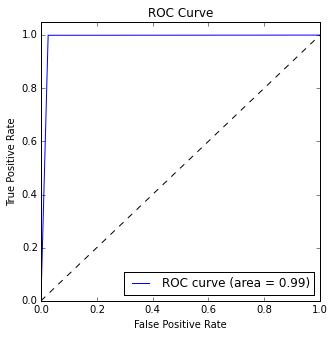

In [17]:
%%local
%matplotlib inline
from sklearn.metrics import roc_curve,auc

sqlResults['probFloat'] = sqlResults.apply(lambda row: row['probability'].values()[0][1], axis=1)
predictions_pddf = sqlResults[["tipped","probFloat"]]

#predictions_pddf = sqlResults.rename(columns={'_1': 'probability', 'tipped': 'label'})
prob = predictions_pddf["probFloat"] 
fpr, tpr, thresholds = roc_curve(predictions_pddf['tipped'], prob, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Create Random Forest classification model using Spark ML RandomForestClassifier function, and evaluate model on test-data

In [18]:
val starttime = Calendar.getInstance().getTime()

// Random Forest Classifier with Spark ML
val rf = new RandomForestClassifier().setLabelCol("labelBin").setFeaturesCol("featuresCat").setNumTrees(10).setSeed(1234)

// Fit the model
val rfModel = rf.fit(indexedTRAINwithCatFeatBinTarget)
val predictions = rfModel.transform(indexedTESTwithCatFeatBinTarget)

val evaluator = new MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("f1")
val Test_f1Score = evaluator.evaluate(predictions)
println("F1 score on test data: " + Test_f1Score);

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

//* Binary classification evaluation metrics*//
val evaluator = new BinaryClassificationEvaluator().setLabelCol("label").setRawPredictionCol("probability").setMetricName("areaUnderROC")
val ROC = evaluator.evaluate(predictions)
println("ROC on test data = " + ROC)

ROC on test data = 0.9847103571552683

### Create Gradient boosting tree classification model using MLlib's GradientBoostedTrees function, and evaluate model on test-data

In [19]:
// Train a GBT Classiication model using MLlib and LabeledPoint
val starttime = Calendar.getInstance().getTime()

val boostingStrategy = BoostingStrategy.defaultParams("Classification")
boostingStrategy.numIterations = 20
boostingStrategy.treeStrategy.numClasses = 2
boostingStrategy.treeStrategy.maxDepth = 5
boostingStrategy.treeStrategy.categoricalFeaturesInfo = Map[Int, Int]((0,2),(1,2),(2,6),(3,4))

val gbtModel = GradientBoostedTrees.train(indexedTRAINbinary, boostingStrategy)

// Save Model in blob location
val datestamp = Calendar.getInstance().getTime().toString.replaceAll(" ", ".").replaceAll(":", "_");
val modelName = "GBT_Classification__"
val filename = modelDir.concat(modelName).concat(datestamp)
gbtModel.save(sc, filename);

// Evaluate model on test instances and compute test error
val labelAndPreds = indexedTESTbinary.map { point =>
  val prediction = gbtModel.predict(point.features)
  (point.label, prediction)
}
val testErr = labelAndPreds.filter(r => r._1 != r._2).count.toDouble / indexedTRAINbinary.count()
//println("Learned classification GBT model:\n" + gbtModel.toDebugString)
println("Test Error = " + testErr)

// Use Binary and Multiclass Metrics to evaluate model on Test data
val metrics = new MulticlassMetrics(labelAndPreds)
println(s"Precision: ${metrics.precision}")
println(s"Recall: ${metrics.recall}")
println(s"F1 Score: ${metrics.fMeasure}")

val metrics = new BinaryClassificationMetrics(labelAndPreds)
println(s"Area under PR curve: ${metrics.areaUnderPR}")
println(s"Area under ROC curve: ${metrics.areaUnderROC}")

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

println(s"Area under ROC curve: ${metrics.areaUnderROC}")

Area under ROC curve: 0.9846895479241554

<hr>

<a name="regression"></a>
## 5. REGRESSION MODEL TRAINING: Predicting tip amount

### Create Linear Regression model using Spark ML LinearRegression function, save model and evaluate model on test-data

In [20]:
// Create Regularized Linear Regression model using Spark ML function and data-frame
val starttime = Calendar.getInstance().getTime()

val lr = new LinearRegression().setLabelCol("tip_amount").setFeaturesCol("features").setMaxIter(10).setRegParam(0.3).setElasticNetParam(0.8)

// Fit the model using data-frame
val lrModel = lr.fit(OneHotTRAIN)
println(s"Coefficients: ${lrModel.coefficients} Intercept: ${lrModel.intercept}")

// Summarize the model over the training set and print out some metrics
val trainingSummary = lrModel.summary
println(s"numIterations: ${trainingSummary.totalIterations}")
println(s"objectiveHistory: ${trainingSummary.objectiveHistory.toList}")
trainingSummary.residuals.show()
println(s"RMSE: ${trainingSummary.rootMeanSquaredError}")
println(s"r2: ${trainingSummary.r2}")

// Save Model in blob
val datestamp = Calendar.getInstance().getTime().toString.replaceAll(" ", ".").replaceAll(":", "_");
val modelName = "LinearRegression__"
val filename = modelDir.concat(modelName).concat(datestamp)
lrModel.save(filename);

// Print coefficients
println(s"Coefficients: ${lrModel.coefficients} Intercept: ${lrModel.intercept}")

// score the model on test data.
val predictions = lrModel.transform(OneHotTEST)

// evaluate the model on Test data
val evaluator = new RegressionEvaluator().setLabelCol("tip_amount").setPredictionCol("prediction").setMetricName("r2")
val r2 = evaluator.evaluate(predictions)
println("R-sqr on test data = " + r2)

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

Time taken to run the above cell: 13 seconds.

##### EXAMPLE: Load a saved LinearRegression model from blob and score test data-set

In [21]:
val starttime = Calendar.getInstance().getTime()

val savedModel = org.apache.spark.ml.regression.LinearRegressionModel.load(filename)
println(s"Coefficients: ${savedModel.coefficients} Intercept: ${savedModel.intercept}")

// score the model on test data.
val predictions = savedModel.transform(OneHotTEST).select("tip_amount","prediction")
predictions.registerTempTable("testResults")

// evaluate the model on Test data
val evaluator = new RegressionEvaluator().setLabelCol("tip_amount").setPredictionCol("prediction").setMetricName("r2")
val r2 = evaluator.evaluate(predictions)
println("R-sqr on test data = " + r2)

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

println("R-sqr on test data = " + r2)

R-sqr on test data = 0.5960320470835743

##### Example: Query test results as data-frame and visualize using Jupyter autoviz & Python matplotlib

In [22]:
%%sql -q -o sqlResults
select * from testResults

In [23]:
%%local
sqlResults

##### Create plots using Python matplotlib

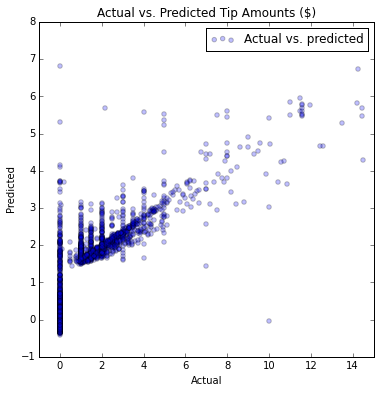

In [24]:
%%local
sqlResults
%matplotlib inline
import numpy as np

ax = sqlResults.plot(kind='scatter', figsize = (6,6), x='tip_amount', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(sqlResults['tip_amount'], sqlResults['prediction'], deg=1)
ax.set_title('Actual vs. Predicted Tip Amounts ($)')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
#ax.plot(sqlResults['tip_amount'], fit[0] * sqlResults['prediction'] + fit[1], color='magenta')
plt.axis([-1, 15, -1, 8])
plt.show(ax)

### Create Gradient boosting tree regression model using Spark ML GBTRegressor function, and evaluate model on test-data

In [25]:
val starttime = Calendar.getInstance().getTime()

// Train a GBT Regression model.
val gbt = new GBTRegressor().setLabelCol("label").setFeaturesCol("featuresCat").setMaxIter(10)
val gbtModel = gbt.fit(indexedTRAINwithCatFeat)

// Make predictions.
val predictions = gbtModel.transform(indexedTESTwithCatFeat)

// Compute Test set R2
val evaluator = new RegressionEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("r2")
val Test_R2 = evaluator.evaluate(predictions)


/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

println("Test R-sqr is: " + Test_R2);

Test R-sqr is: 0.7655383534596654

<hr>

<a name="advanced"></a>
## 6. ADVANCED MODELING UTILITIES: In this section, we show ML utilities that are frequently used for model optimization

<b>We show three different ways to optimize ML models using parameter sweeping:</b>
1. Split data into train & validation sets, optimize model using hyper-parameter sweeeping on training set and evaluation on validation set (Linear Regression)
2. Optimize model using cross-validation and hyper-parameter sweeping, using Spark ML's CrossValidator function (Binary Classification)
3. Optimize model using custom cross-validation and parameter-sweeping code to to utilize any ML function and parameter-set (Linear Regression)

### Split data into train & validation sets, optimize model using hyper-parameter sweeeping on training set and evaluation on validation set (Linear Regression)

In [26]:
val starttime = Calendar.getInstance().getTime()

// Rename tip_amount as label
val OneHotTRAINLabeled = OneHotTRAIN.select("tip_amount","features").withColumnRenamed(existingName="tip_amount",newName="label") 
val OneHotTESTLabeled = OneHotTEST.select("tip_amount","features").withColumnRenamed(existingName="tip_amount",newName="label")
OneHotTRAINLabeled.cache()
OneHotTESTLabeled.cache()

// Define the estimator function: LineareRegression function
val lr = new LinearRegression().setLabelCol("label").setFeaturesCol("features").setMaxIter(10)

// Define parameter grid
val paramGrid = new ParamGridBuilder().addGrid(lr.regParam, Array(0.1, 0.01, 0.001)).addGrid(lr.fitIntercept).addGrid(lr.elasticNetParam, Array(0.1, 0.5, 0.9)).build()

// Define pipeline with train-validation split, with 75% in training set, specify estimator, evaluator, parameter grid
val trainPct = 0.75
val trainValidationSplit = new TrainValidationSplit().setEstimator(lr).setEvaluator(new RegressionEvaluator).setEstimatorParamMaps(paramGrid).setTrainRatio(trainPct)

// Run train validation split, and choose the best set of parameters.
val model = trainValidationSplit.fit(OneHotTRAINLabeled)

// Make predictions on test data. model is the model with combination of parameters that performed best.
val testResults = model.transform(OneHotTESTLabeled).select("label", "prediction")

// Compute Test set R2
val evaluator = new RegressionEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("r2")
val Test_R2 = evaluator.evaluate(testResults)

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

println("Test R-sqr is: " + Test_R2);

Test R-sqr is: 0.6226484708501209

### Optimize model using cross-validation and hyper-parameter sweeping, using Spark ML's CrossValidator function (Binary Classification)

In [27]:
val starttime = Calendar.getInstance().getTime()

// Create data-frames with properly labeled columns for use with train/test split
val indexedTRAINwithCatFeatBinTargetRF = indexedTRAINwithCatFeatBinTarget.select("labelBin","featuresCat").withColumnRenamed(existingName="labelBin",newName="label").withColumnRenamed(existingName="featuresCat",newName="features")
val indexedTESTwithCatFeatBinTargetRF = indexedTESTwithCatFeatBinTarget.select("labelBin","featuresCat").withColumnRenamed(existingName="labelBin",newName="label").withColumnRenamed(existingName="featuresCat",newName="features")
indexedTRAINwithCatFeatBinTargetRF.cache()
indexedTESTwithCatFeatBinTargetRF.cache()

// Define the estimator function
val rf = new RandomForestClassifier().setLabelCol("label").setFeaturesCol("features").setImpurity("gini").setSeed(1234).setFeatureSubsetStrategy("auto").setMaxBins(32)

// Define parameter grid
val paramGrid = new ParamGridBuilder().addGrid(rf.maxDepth, Array(4,8)).addGrid(rf.numTrees, Array(5,10)).addGrid(rf.minInstancesPerNode, Array(100,300)).build()

// Specify number of folds
val numFolds = 3

// Define train-test validation split, with 75% in training set
val CrossValidator = new CrossValidator().setEstimator(rf).setEvaluator(new BinaryClassificationEvaluator).setEstimatorParamMaps(paramGrid).setNumFolds(numFolds)

// Run train validation split, and choose the best set of parameters.
val model = CrossValidator.fit(indexedTRAINwithCatFeatBinTargetRF)

// Make predictions on test data. model is the model with combination of parameters that performed best.
val testResults = model.transform(indexedTESTwithCatFeatBinTargetRF).select("label", "prediction")

// Compute Test F1 score
val evaluator = new MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("f1")
val Test_f1Score = evaluator.evaluate(testResults)

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

Time taken to run the above cell: 33 seconds.

### Optimize model using custom cross-validation and parameter-sweeping code to utilize any ML function and parameter-set (Linear Regression)

#### Optimize model using custom code. Then identify best model parameters based on highest accuracy, create final model, and evaluate model on test data. Save model in blog. Load model and score test-data and evaluate accuracy.

In [28]:
val starttime = Calendar.getInstance().getTime()

// Define parameter grid and number of folds
val paramGrid = new ParamGridBuilder().addGrid(rf.maxDepth, Array(5,10)).addGrid(rf.numTrees, Array(10,25,50)).build()

val nFolds = 3
val numModels = paramGrid.size
val numParamsinGrid = 2

// Specify the number of categories of categorical variables
val categoricalFeaturesInfo = Map[Int, Int]((0,2),(1,2),(2,6),(3,4))

var maxDepth = -1
var numTrees = -1
var param = ""
var paramval = -1
var validateLB = -1.0
var validateUB = -1.0
val h = 1.0 / nFolds;
val RMSE  = Array.fill(numModels)(0.0)

// Create k folds
val splits = MLUtils.kFold(indexedTRAINbinary, numFolds = nFolds, seed=1234)


// Loop through k-folds and parameter grid to get and identify best parameter set by best accuracy
for (i <- 0 to (nFolds-1)) {
    validateLB = i * h
    validateUB = (i + 1) * h
    val validationCV = trainData.filter($"rand" >= validateLB  && $"rand" < validateUB)
    val trainCV = trainData.filter($"rand" < validateLB  || $"rand" >= validateUB)
    val validationLabPt = validationCV.rdd.map(r => LabeledPoint(r.getDouble(targetIndRegression(0).toInt), Vectors.dense(featuresIndIndex.map(r.getDouble(_)).toArray)));
    val trainCVLabPt = trainCV.rdd.map(r => LabeledPoint(r.getDouble(targetIndRegression(0).toInt), Vectors.dense(featuresIndIndex.map(r.getDouble(_)).toArray)));
    validationLabPt.cache()
    trainCVLabPt.cache()

    for (nParamSets <- 0 to (numModels-1)) {
        for (nParams <- 0 to (numParamsinGrid-1)) {
            param = paramGrid(nParamSets).toSeq(nParams).param.toString.split("__")(1)
            paramval = paramGrid(nParamSets).toSeq(nParams).value.toString.toInt
            if (param == "maxDepth") {maxDepth = paramval}
            if (param == "numTrees") {numTrees = paramval}
        }
        val rfModel = RandomForest.trainRegressor(trainCVLabPt, categoricalFeaturesInfo=categoricalFeaturesInfo,
                                                  numTrees=numTrees, maxDepth=maxDepth,
                                                  featureSubsetStrategy="auto",impurity="variance", maxBins=32)
        val labelAndPreds = validationLabPt.map { point =>
                                                 val prediction = rfModel.predict(point.features)
                                                 ( prediction, point.label )
                                                }
        val validMetrics = new RegressionMetrics(labelAndPreds)
        val rmse = validMetrics.rootMeanSquaredError
        RMSE(nParamSets) += rmse
    }
    validationLabPt.unpersist();
    trainCVLabPt.unpersist();
}
val minRMSEindex = RMSE.indexOf(RMSE.min)

// Get  best parameters from CV and parameter sweep
var best_maxDepth = -1
var best_numTrees = -1
for (nParams <- 0 to (numParamsinGrid-1)) {
    param = paramGrid(minRMSEindex).toSeq(nParams).param.toString.split("__")(1)
    paramval = paramGrid(minRMSEindex).toSeq(nParams).value.toString.toInt
    if (param == "maxDepth") {best_maxDepth = paramval}
    if (param == "numTrees") {best_numTrees = paramval}
}

// Create best model with best parameters and full training data-set
val best_rfModel = RandomForest.trainRegressor(indexedTRAINreg, categoricalFeaturesInfo=categoricalFeaturesInfo,
                                                  numTrees=best_numTrees, maxDepth=best_maxDepth,
                                                  featureSubsetStrategy="auto",impurity="variance", maxBins=32)

// Save best RF model in blob
val datestamp = Calendar.getInstance().getTime().toString.replaceAll(" ", ".").replaceAll(":", "_");
val modelName = "BestCV_RF_Regression__"
val filename = modelDir.concat(modelName).concat(datestamp)
best_rfModel.save(sc, filename);

// Predict on Training set with best model and evaluate
val labelAndPreds = indexedTESTreg.map { point =>
                                        val prediction = best_rfModel.predict(point.features)
                                        ( prediction, point.label )
                                       }

val test_rmse = new RegressionMetrics(labelAndPreds).rootMeanSquaredError
val test_rsqr = new RegressionMetrics(labelAndPreds).r2

/* GET TIME TO RUN THE CELL */
val endtime = Calendar.getInstance().getTime()
val elapsedtime =  ((endtime.getTime() - starttime.getTime())/1000).toString;
println("Time taken to run the above cell: " + elapsedtime + " seconds.");

Time taken to run the above cell: 61 seconds.

##### Load best RF model from blob and score test file

In [29]:
val savedRFModel = RandomForestModel.load(sc, filename)

val labelAndPreds = indexedTESTreg.map { point =>
                                        val prediction = savedRFModel.predict(point.features)
                                        ( prediction, point.label )
                                       }
val test_rmse = new RegressionMetrics(labelAndPreds).rootMeanSquaredError
val test_rsqr = new RegressionMetrics(labelAndPreds).r2

test_rsqr: Double = 0.785399549439923

<hr>

<a name="consumption"></a>
## 7. AUTOMATICALLY CONSUMING SPARK-BUILT ML MODELS

We have previously published a description and code (pySpark) to show how one can automatically load and score new data-sets with ML models built in Spark and saved in Azure blobs. We do not repeat that description here, but simply point the users to the <a href="https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-spark-overview/" target="_blank">previously published description on automated model consumption</a>. Users need to follow the instructions provided earlier, and replace the python code with Scala code shown above to enable automated consumption.

<hr>

In [30]:
/* GET TIME TO RUN THE NOTEBOOK */
val finalTime = Calendar.getInstance().getTime()
val totalTime =  ((finalTime.getTime() - beginningTime.getTime())/1000).toString;
println("Time taken to run the above cell: " + totalTime + " seconds.");

Time taken to run the above cell: 286 seconds.